# Opdracht 2 - Convolutional Neural Networks


Het doel van deze opdracht is om image recognition te doen aan de hand van Convolutional Neural Networks (CNN). In een eerste deelopdracht ontwerp je een binaire CNN classifier voor het classificeren van foto's van lichaamscellen die al dan niet met malaria geïnfecteerd zijn. 

In een tweede deelopdracht zal je gezichtsherkenning uitvoeren via een multi-class CNN classifier.

In een derde deelopdracht train je een CNN die gezichten van niet-gezichten kan onderscheiden. Met deze classifier kan je vervolgens gezichtsdetectie uitvoeren. Daarbij is het niet de bedoeling om gezichten te herkennen, maar de locatie van al dan niet aanwezig gezichten in afbeeldingen te vinden en aan te duiden.

Na deze opdracht zal je vertrouwd zijn met:
- Implementeren van convolutional neural networks voor objectherkenning in afbeeldingen.
- Hyperparameter tuning van CNN's
- Weten hoe je transfer learning kan toepassen voor jouw eigen classificatie taak.
- Data/Image augmentation uitvoeren.
- Object detectie via een sliding window.


In [24]:
%matplotlib inline
import os
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
import matplotlib.image as mpimg
from skimage.io import imread, imsave, imshow
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage
import sklearn.metrics as metrics
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

# Some defaults for matplotlib
LARGE = 12
MEDIUM = 10
SMALL = 6
plt.tight_layout()
plt.rcParams.update({
    'axes.titlesize': MEDIUM,
    'legend.fontsize': SMALL,
    'figure.figsize': (5, 3),
    'axes.labelsize': MEDIUM,
    'axes.titlesize': MEDIUM,
    'xtick.labelsize': SMALL,
    'ytick.labelsize': SMALL,
    'figure.titlesize': LARGE
})

# Reproducibility of the results
SEED = 42
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(SEED)

###### Voor Tensorflow-GPU ########
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

#K.set_image_dim_ordering('tf')
plt.rcParams['image.cmap'] = 'gray'
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<Figure size 640x480 with 0 Axes>

## Malaria Classification

Ontwerp en train een CNN dat is in staat is met Malaria geïnfecteerde cellen van niet-geïnfecteerde cellen te onderscheiden.

De data is te vinden in:
- './Malaria/train/infected/': afbeelding van met Malaria geïnfecteerde cellen om mee te trainen.
- './Malaria/train/uninfected/': afbeeldingen van gezonde, niet-geïnfecteerde cellen om mee te trainen.
- './Malaria/test/infected/': afbeelding van met Malaria geïnfecteerde cellen om mee te testen.
- './Malaria/test/uninfected/': afbeeldingen van gezonde, niet-geïnfecteerde cellen om mee te testen.


1. Ontwerp in eerste instantie een eigen CNN. 
- Probeer de accuracy van het CNN op de test data zo hoog mogelijk te krijgen. Dit kan bijvoorbeeld omvatten: hyperparameter tuning van de het netwerk zelf, early stopping, image augmentation of eigen bedachte (pre)-processing technieken. 
- Stel nu dat aan het CNN de vereiste wordt gesteld dat het aantal false negatives (het netwerk voorspelt niet-geïnfecteerd terwijl ze wel geïnfecteerd zijn) op de test set maximaal 1% mag bedragen. Welke aanpassingen zou je doen? Voor deze aanpassingen uit en toon aan dat het aantal false negatives tot maximum 1% is gezakt. Welke accuracy haal je nog?

2. Voer transfer learning uit. Hertrain het VGG19 netwerk voor het classificeren van de al dan niet met Malaria geïnfecteerde cellen. Vergelijk de resultaten met deze van het eigen CNN in termen van accuraatheid, f1-score, snelheid van training, de benodigde hoeveelheid training data, etc.



### Eigen CNN

In [29]:
# Inlezen van de data

# Lezen en preprocessen 

image_size = 100  # hoogte en breedte van de afbeeldingen na resizing. Pas gerust aan.
nr_train_images = 10  # Om het aantal afbeelding in de training set te beperken. Verhoog indien jouw systeem het toelaat.
nr_test_images = 10 # Om het aantal afbeelding in de test set in eerste instantiete beperken. 
infected_train_images = []
infected_test_images = []
uninfected_train_images = []
uninfected_test_images = []
y_infected_train = []
y_uninfected_train = []
y_infected_test = []
y_uninfected_test = []
infected_train_label = []
infected_test_label = []
uninfected_train_label = []
uninfected_test_label = []

# read infected train_images
path = './Malaria/train/infected/'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_train_images]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f))
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    infected_train_images.append(im)
    y_infected_train.append(1)
    infected_train_label.append(f)
    
# read infected test_images

path = './Malaria/test/infected/'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_test_images]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f))
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    infected_test_images.append(im)
    y_infected_test.append(1)
    infected_test_label.append(f)
    

# read uninfected train_images
path = './Malaria/train/uninfected/'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_train_images]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f)) 
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    uninfected_train_images.append(im)
    y_uninfected_train.append(0)
    uninfected_test_label.append(f)


# read uninfected test_images

path = './Malaria/test/uninfected/'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_test_images]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f)) 
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    uninfected_test_images.append(im)
    y_uninfected_test.append(0)
    uninfected_train_label.append(f)
    


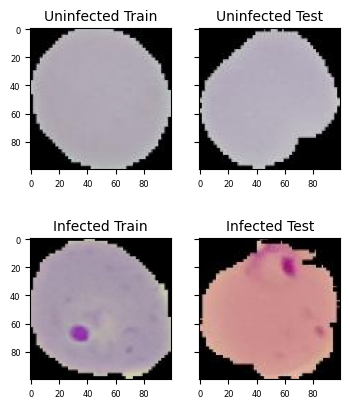

In [27]:
# Toon een aantal afbeeldingen afbeelding
# fig, axes = plt.subplots(2, 2, sharey=True)
fig, axes = plt.subplots(2, 2, figsize = (4, 5), sharey=True)
axes[0,0].set_title("Uninfected Train")
axes[0,0].imshow(uninfected_train_images[1])
axes[0,1].set_title("Uninfected Test")
axes[0,1].imshow(uninfected_test_images[1])
axes[1,0].set_title("Infected Train")
axes[1,0].imshow(infected_train_images[1])
axes[1,1].set_title("Infected Test")
axes[1,1].imshow(infected_test_images[1])

# plt.imshow(uninfected_train_images[1])

In [33]:
print(infected_train_label[0:10])
print(uninfected_train_label[0:10])

['train_infected_8294.jpg', 'infected_2752_.jpg', 'train_infected_7315.jpg', 'train_infected_2569.jpg', 'train_infected_1928.jpg', 'infected_861_.jpg', 'train_infected_1129.jpg', 'infected_2453_.jpg', 'train_infected_6880.jpg', 'train_infected_3518.jpg']
['test_uninfected_2783.jpg', 'test_uninfected_1690.jpg', 'test_uninfected_1237.jpg', 'test_uninfected_2845.jpg', 'test_uninfected_2548.jpg', 'test_uninfected_2210.jpg', 'test_uninfected_555.jpg', 'test_uninfected_2514.jpg', 'test_uninfected_2980.jpg', 'test_uninfected_1657.jpg']


In [43]:
# Creëer te de test set en training set. Zorg ervoor dat ze gerandomiseerd zijn.
X_train, y_train = shuffle(uninfected_train_images + infected_train_images,  y_uninfected_train + y_infected_train, random_state=0)
print(y_train[0:20])
X_test, y_test = shuffle(uninfected_test_images + infected_test_images,  y_uninfected_test + y_infected_test, random_state=1)
print(y_test[0:20])


[0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]


In [47]:
# Normalisatie van de data
print(uninfected_train_images[0])
uninfected_train_images[0].shape
# Find the maximum value in the array
max_value = np.amax(uninfected_train_images)

# Print the maximum value
print("The maximum value in the array is:", max_value)


[[[0.         0.00392157 0.        ]
  [0.         0.00392157 0.        ]
  [0.         0.         0.00784314]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.00392157 0.        ]
  [0.         0.00392157 0.        ]
  [0.         0.         0.00784314]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.00392157 0.00784314]
  [0.         0.00392157 0.00784314]
  [0.         0.         0.00784314]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


In [ ]:
# CNN




In [1]:
# Testen van het neuraal netwerk op de test set. Kijk naar de accuracy, recall, precision, f1-score en de ROC 



In [3]:
# Optimalisatie van het netwerk



In [ ]:
# Visualiseer enkele verkeerd geclassificeerde afbeeldingen van de ene klasse en van de andere klasse. 


In [ ]:
# Verminderen van het aantal false negatives tot max 1%.



**Schrijf hier jouw conclusies:**



### Transfer learning
Hertrain het VGG19 netwerk (of optioneel ResNet) op de malaria dataset. Vergelijk de resultaten met deze van het eigen CNN in termen van accuraatheid, f1-score, snelheid van training, de benodigde hoeveelheid training data, etc.

In [10]:
# transfer learning


#modelVGG19 = tf.keras.applications.vgg19.VGG19()
modelVGG19 = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(100,100,3))
type(modelVGG19)


# Converteer naar een sequential model.


    
# Zet de gewichten van feature extraction layers vast.


# Voeg dense layers toe.


tensorflow.python.keras.engine.training.Model

**Schrijf hier jouw conclusies:**


## Face recognition

Train een eigen CNN dat als taak heeft een zo accuraat mogelijke gezichtsherkenning uit te voeren op een gezichtsdataset van celebrities.

Er zijn twee gezichtsdatasets beschikbaar:

'./Face_Recognition/15_Classes' bevat gezichten van 15 verschillende celbrities.
'./Face_Recognition/100_Classes' bevat gezichten van 100 verschillende celebrities.

Werk in eerste instantie met de 15_classes dataset. 


### 15 classes dataset - eigen CNN

In [8]:
# Inlezen en preprocessen van de afbeeldingen
# nr_of_images = 5000
image_size = 100


faces = []
labels = []
# read infected train_images
path = './Face_Recognition/15_Classes'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f)) 
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    faces.append(im)
    #s = re.sub('[0-9]\w+', '', f)
    s = os.path.splitext(f)[0]
    s = ''.join([i for i in s if not i.isdigit()])
    s = s.replace("_", "")
    labels.append(s)

In [ ]:
# Creëer een training set en test set. Zorg ervoor dat 30 procent van de afbeeldingen in de test set zitten.



In [ ]:
# Convolutional Neural Network



In [ ]:
# Testen van het CNN



In [4]:
# Hyperparameter tuning en image augmentation. 


**Schrijf hier jouw conclusies neer:**

### Transfer learning by means of VGG19

Hertrain een VGG19 net (of Resnet).

In [5]:
# VGG19


**Schrijf hier jouw conclusies neer:**

### 100 classes dataset

Probeer nu classificatie te doen op de 100_classes dataset. Tranfer learning hoeft niet. Vergelijk de resultaten met de performantie op de 15_classes dataset. Evalueer en verklaar de resultaten.

In [6]:
# Herkenning van 100 classes dataset



**Schrijf hier jouw conclusies neer:**

## Face detection 


Het doel is het ontwerpen van een CNN die met een hoge accuraatheid in staat is om gezichten te detecteren waarna rond het gezicht een bounding box getekend wordt. 
Bijvoorbeeld:
![alt text](./Jupyter_Images/Face_Detection.png) 

Doorloop de volgede stappen:
- Compileer een training set met gezichten en niet-gezichten. Online zijn verschillende gezichtsdatasets te vinden. Bijvoorbeeld: https://lionbridge.ai/datasets/5-million-faces-top-15-free-image-datasets-for-facial-recognition/ en http://shuoyang1213.me/WIDERFACE/
- Train een CNN (mag via transfer learning, maar hoeft niet) die met een hoge accuraatheid gezichten van niet-gezichten kan onderscheiden.
- Test deze CNN om een idee te hebben van de classifiation accuracy. 
- Indien de performantie voldoende hoog is kan je een sliding window detector implementeren. Dit betekent dat je de test-afbeelding meerdere keren afscant met een sliding window van verschillende groottes. Het CNN zal voor elke positie van het sliding window een classificatie doen van de subimage die onder het window is gelegen. Teken een bounding box wanneer de subimage een gezicht bevat.

Voor het tekenen van een bounding box kan de volgende code gebruikt worden:

```python
def rectangle_perimeter(r0, c0, width, height, shape=None, clip=False):
    rr, cc = [r0, r0 + width, r0 + width, r0], [c0, c0, c0 + height, c0 + height]
    return skimage.draw.polygon_perimeter(rr, cc, shape=shape, clip=clip)

# drawing the bounding box:
rr, cc = rectangle_perimeter(y, x, w, w)
image_detected[rr,cc] =255

```

Extra uitbreiding:

Probleem: omdat we de afbeelding meerdere keren afscannen, telkens met windows van verschillende grootte is het goed mogelijk dat er meerdere bounding boxes worden geteked rond hetzelfde gezicht. Zoek naar een manier om meerdere bounding boxes die bij hetzelfde gezicht horen samen te voegen tot 1 bounding box.
Een veel gebruikte techniek is Non-Maximum Suppression: https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/ en https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/.